# Kaggle-Titanic

## 目标 Objective
根据训练集中乘客的信息来预测测试集中的乘客是否存活（二分类问题）

## 1 数据分析
### 1.1 引入需要的包

In [1]:
%matplotlib inline
import numpy as np                                     ## 用于数据分析
import pandas as pd                                    ## 用于数据分析
import seaborn as sns                                  ## 用于数据可视化
import matplotlib.pyplot as plt                        ## 用于数据可视化
import re                                              ## 用于进行正则表达式的提取
import xgboost as xgb                                  ## 用于实现 xgboost
from sklearn.tree import DecisionTreeRegressor         ## 用于实现回归决策树
import sklearn.preprocessing as preprocessing          ## 用于进行变量标准化
from sklearn.model_selection import train_test_split   ## 分割训练集与测试集用于模型训练和预测
from sklearn.linear_model import LogisticRegression    ## 用于构建逻辑回归模型
from sklearn.svm import SVC                            ## 用于构建支持向量机
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier) ## 用于实现这四类模型
from sklearn.metrics import accuracy_score             ## 用于检测线性/多项式模型的准确度
from sklearn.model_selection import learning_curve     ## 用于查看模型的学习曲线
from sklearn import metrics                            ## 用于实现指标相关的操作
from sklearn.model_selection import KFold              ## 实现 K 折交叉验证
import warnings                                        ## 用于避免出现 Warning
warnings.filterwarnings("ignore")

## 1.2 加载数据

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

all_data = [train, test]

## 1.3 数据预览与可视化统计

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


可以看到共有 12 个字段，含义如下：
* PassengerId => 乘客Id
* Survived => 是否存活（1=存活，2=遇难）
* Pclass => 舱位级别 (1=一等舱，2=二等舱，3=三等舱）
* Name => 姓名
* Sex => 性别 (male 男性，female 女性）
* Age => 年龄
* SibSp => 同行的兄弟姐妹或配偶总数 (Sibling or Spouse）
* Parch => 同行的父母或孩子总数 （Parent or Children）
* Ticket => 票号
* Fare => 票价
* Cabin => 船舱号
* Embarked => 登船港口（C=Cherbourg（瑟堡），Q=Queenstown（皇后镇），S=Southampton（南安普敦））

PassengerId 只是一个序号，暂且删除。把测试集的乘客 Id 额外存起来，方便后续调用。

In [4]:
Pid_test=test['PassengerId']
for i in all_data:
    i.drop('PassengerId',axis=1,inplace=True)

In [5]:
# 查看缺失值情况-训练集
train.isnull().sum().to_frame().T

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,0,0,0,177,0,0,0,0,687,2


In [6]:
# 查看缺失值情况-测试集
test.isnull().sum().to_frame().T

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,0,0,86,0,0,0,1,327,0


可以发现：
* 训练集中有 177 条数据缺失年龄(Age)信息，687 条数据缺失船舱号(Cabin)信息，以及 2 条数据缺失登船港口（Embarked）信息。
* 测试集中有 86 条数据缺失年龄(Age)信息，1 条数据缺失票价(Fare)信息，以及 327 条数据缺失船舱号(Cabin)信息。

接下来看下，各个变量的分布特征

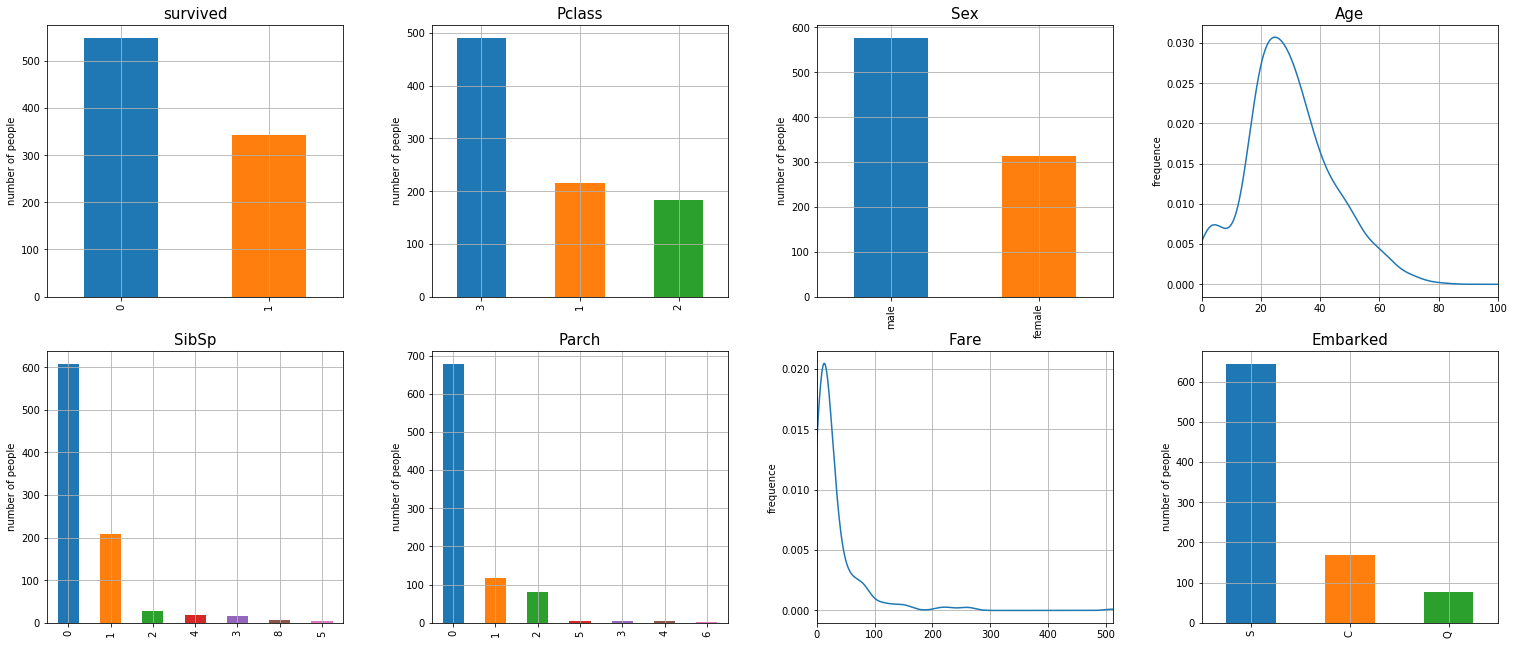

In [7]:
# 查看各个特征的分布情况
fig = plt.figure(figsize=(26,11))
fig.subplots_adjust(hspace=0.2, wspace=0.3)

for i in range(1,9):
    
    ax = fig.add_subplot(2,4,i)
    
    if i==1:
        train.Survived.value_counts().plot(kind='bar')
        plt.title("survived",size=15)
        plt.ylabel("number of people")  
        plt.grid(b=True)
    elif i==2:
        train.Pclass.value_counts().plot(kind='bar')
        plt.title("Pclass",size=15)
        plt.ylabel("number of people")  
        plt.grid(b=True)
    elif i==3:
        train.Sex.value_counts().plot(kind='bar')
        plt.title("Sex",size=15)
        plt.ylabel("number of people")  
        plt.grid(b=True)
    elif i==4:
        train.Age.plot(kind='kde')
        plt.title("Age",size=15)
        plt.ylabel("frequence")
        plt.xlim(0,100)
        plt.grid(b=True)
    elif i==5:
        train.SibSp.value_counts().plot(kind='bar')
        plt.title("SibSp",size=15)
        plt.ylabel("number of people")  
        plt.grid(b=True)
    elif i==6:
        train.Parch.value_counts().plot(kind='bar')
        plt.title("Parch",size=15)
        plt.ylabel("number of people")  
        plt.grid(b=True)
    elif i==7:
        train.Fare.plot(kind='kde')
        plt.title("Fare",size=15)
        plt.ylabel("frequence")
        plt.xlim(train.Fare.min(),train.Fare.max())
        plt.grid(b=True)
    else:
        train.Embarked.value_counts().plot(kind="bar")
        plt.title("Embarked",size=15)
        plt.ylabel("number of people")  
        plt.grid(b=True)

可以看出来训练集特征的以下特点：
* 存活人数略大于未存活人数
* 三等舱的人数远远大于一、二等舱
* 男性比女性更多
* 人群年龄比较集中在一个峰值
* 大部分的人都只有 1 位或者没有 SibSp
* 大部分的人都没有 Parch
* 票价非常集中于一个峰值
* 大部分的人都是在 S 港口登船的

那么这些特征和目标变量（Survived）之间的关系可视化一下。

In [8]:
# 构建一个函数，来优化代码，传入参数特征名,绘制类别（1为连续变量，2为类别变量）,子图位置
def plotSur(cate,index,location):
    if index==1:
        Survived_1 = train[cate][train.Survived == 1]
        Survived_0 = train[cate][train.Survived == 0]
        df=pd.DataFrame({'Survived':Survived_1, 'Unsurvived':Survived_0})
        df.plot(kind='kde',ax=location,title=cate)
        location.set_xlim(train[cate].min(),train[cate].max())
        location.set_ylabel("Frequence")
        location.grid(b=True)
    else:
        Survived_0 = train[cate][train.Survived == 0].value_counts()
        Survived_1 = train[cate][train.Survived == 1].value_counts()
        df=pd.DataFrame({'Survived':Survived_1, 'Unsurvived':Survived_0})
        df.plot(kind='bar', stacked=True,ax=location,title=cate)
        location.set_ylabel("Number of People")
        location.grid(b=True)

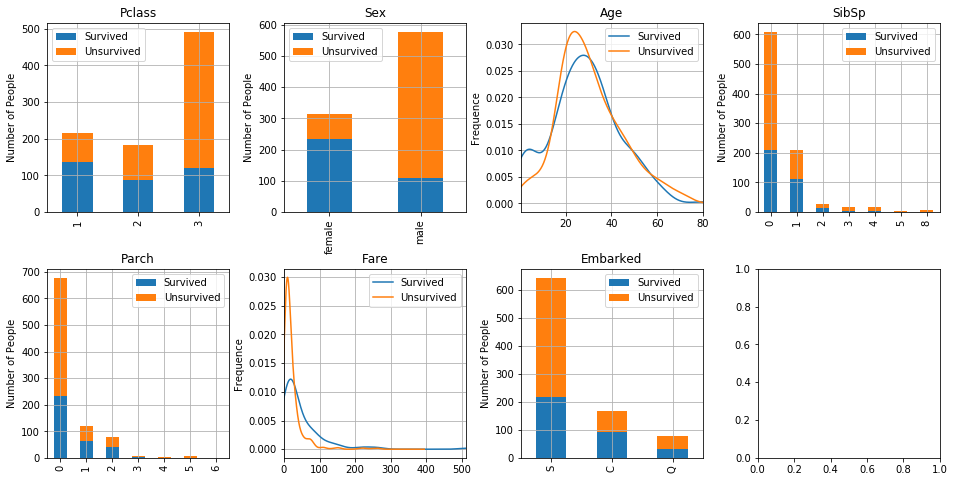

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# Pclass
plotSur('Pclass',2,axes[0,0])
# Sex
plotSur('Sex',2,axes[0,1])
# Age
plotSur('Age',1,axes[0,2])
# SibSp
plotSur('SibSp',2,axes[0,3])
# Parch
plotSur('Parch',2,axes[1,0])
# Fare
plotSur('Fare',1,axes[1,1])
# Embarked
plotSur('Embarked',2,axes[1,2])

plt.show()

可以发现这些特征和目标变量之间有这些信息：

* 舱位等级（Pclass）越高，存活率就越高
* 女性的存活率比男性高很多（应该是在逃难时让妇女优先）
* 儿童的存活率也更高一点 （应该是在逃难时让儿童优先）=> 考虑后面特征工程构造儿童这一特征
* 青壮年的存活率也略低一点 => 如果加上性别的考虑，青壮年男性的存活率会不会很低？
* 当存在 Sibsp 时 Sibsp 数量越多，存活率也越低
* 当存在 Parch 时 Parch 数量在 1-3 时，存活率更高 （猜测可能是单独带小孩、老人，或者是一个小家庭，这种情况下有更高的几率被优先救援）=> 考虑后面特征工程构造家庭这一特征
* 没有 Parch 或 没有 Sibsp 的人的存活率都比较低 => 考虑综合考虑这两个特征，是否单独一人出行的存活率会很低？
* 票价在较低的区间，存活率会更低；在较高的区间，存活率会更高一点；而在 200~400，没有看出很大的差别；在 400 以上，存活率非常高了 （猜测可能票价是和客舱位置有关的） => 综合客舱等级（Pclass）或许会有所发现，或者将其根据这点发现分成 4 个区间划分
* 在 S 港口上船的存活率比其他两个港口更低

## 2 数据预处理
### 2.1 处理缺失值
训练集有三个特征需要处理，分别是 Age(177), Cabin(687) 和 Embarked(2)。

一般来说，缺失值有以下的处理方法：
* 如果缺值的样本占总数比例极高，我们可能就直接舍弃了，作为特征加入的话，可能反倒带入 noise，影响最后的结果
* 如果缺值的样本适中，而该属性非连续值特征属性（比如说类目属性），那就把 NaN 作为一个新类别，加到类别特征中
* 如果缺值的样本适中，而该属性为连续值特征属性，有时候我们会考虑给定一个 step，然后把它离散化，之后把 NaN 作为一个 type 加到属性类目中
* 有些情况下，缺失的值个数并不是特别多，那我们也可以试着根据已有的值，拟合一下数据，补充上

=> Embarked 缺失的数量很少，我们直接填充为出现最多的 S 港口。<br>
=> Cabin 考虑只取第一位字母（猜测代表了客舱的位置），然后使用第二种方法填充<br>
=> Age 考虑使用第三种方法

In [10]:
# 填充 Embarked
train['Embarked']=train['Embarked'].fillna('S')

In [11]:
# 处理 Cabin，形成新特征 客舱号 CabinNum
# 删除 Cabin
train['CabinNum']=train['Cabin'].apply(lambda x: 'N' if type(x)==float else x[0])
train.drop('Cabin',axis=1,inplace=True)

In [12]:
# 处理 Age，形成新特征 分层年龄 CategorizedAge,
# 根据上面的密度图将其分为儿童（Children 0~16），成人（Adule 16~40），中年人（Mid 40~60）,老年人（Old >60）,无数据（NaN）四类
# 删除 Age
train['CategorizedAge']=train['Age'].apply(lambda x: 'C' if x<=16 else ('A' if (x>16 and x<=40) else ('M' if (x>40 and x<=60) else ('O' if x>60 else 'N'))))
train.drop('Age',axis=1,inplace=True)

In [13]:
# 查看缺失值情况-训练集
train.isnull().sum().to_frame().T

,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Embarked,CabinNum,CategorizedAge
0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
train.head()

,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Embarked,CabinNum,CategorizedAge
0,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500,S,N,A
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833,C,C,A
2,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,7.9250,S,N,A
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,53.1000,S,C,A
4,0,3,"Allen, Mr. William Henry",male,0,0,373450,8.0500,S,N,A


然后，我们来看下这两个新特征与目标变量之间的关系。

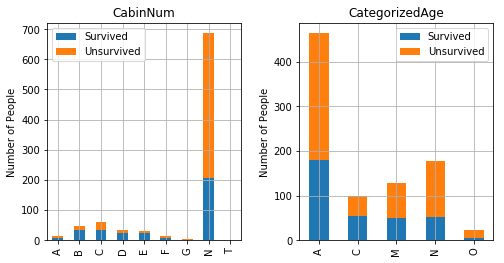

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8, 4))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# CabinNum
plotSur('CabinNum',2,ax1)
# CategorizedAge
plotSur('CategorizedAge',2,ax2)

plt.show()

可以看到都是有一定的区分度的。所以这两个特征是可以的。

### 2.2 One-hot encoding (OHE)
对于一个有m个category的特征，经过独热编码（OHE）处理后，会变为m个二元特征，每个特征对应于一个category。这m个二元特征互斥，每次只有一个激活。

需要OHE的特征有 Pclass, Sex, Emabarked, CabinNum 和 CategorizedAge

In [16]:
def dummiesCate(origin,CateList):
    dummiesList=[origin]
    for Cate in CateList:
        dummiesList.append(pd.get_dummies(origin[Cate],prefix=Cate))
    origin=pd.concat(dummiesList,axis=1)
    origin.drop(CateList,axis=1,inplace=True)
    return origin

In [17]:
train=dummiesCate(train,['Pclass','Sex','Embarked','CabinNum','CategorizedAge'])
train.head()

,Survived,Name,SibSp,Parch,Ticket,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,...,CabinNum_E,CabinNum_F,CabinNum_G,CabinNum_N,CabinNum_T,CategorizedAge_A,CategorizedAge_C,CategorizedAge_M,CategorizedAge_N,CategorizedAge_O
0,0,"Braund, Mr. Owen Harris",1,0,A/5 21171,7.2500,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,PC 17599,71.2833,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,1,"Heikkinen, Miss. Laina",0,0,STON/O2. 3101282,7.9250,0,0,1,1,...,0,0,0,1,0,1,0,0,0,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0,113803,53.1000,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,0,"Allen, Mr. William Henry",0,0,373450,8.0500,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0


## 3 特征工程
### 3.1 特征构建
考虑构建以下新特征：
* NameLen => 姓名长度
* FamilySize => 家庭大小 （FamilySize = SibSp + Parch + 1）
* IsAlone => 是否独行（家庭大小是否为1）
* Title => 姓名的头衔
* Mother => 母亲 （CategorizedAge='A' & Parch>=1）
* CategorizedFare => 分层票价（分为四层A 0-50,B 50-200,C 200-400,D >400）

In [18]:
# NameLen 姓名长度
train['NameLen'] = train['Name'].apply(len)

# FamilySize 家庭大小
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1

# IsAlone 是否独行
train['IsAlone'] = train["FamilySize"].apply(lambda x: 1 if x==1 else 0)

# Title 姓名的头衔
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
train['Title'] = train['Name'].apply(get_title)

# Mother 母亲
train['Mother']=train.apply(lambda x: 1 if (x.CategorizedAge_A==1 and x.Parch>=1) else 0 , axis = 1)

# CategorizedFare 分层票价
train['CategorizedFare']=train.Fare.apply(lambda x: 'A' if x<=50 else ('B' if (x>50 and x<=200) else ('C' if(x>200 and x<=400) else 'D')))

# 删除其他特征
train.drop(['Name','Ticket','Fare'],axis=1,inplace=True)

train.head()

,Survived,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,CategorizedAge_C,CategorizedAge_M,CategorizedAge_N,CategorizedAge_O,NameLen,FamilySize,IsAlone,Title,Mother,CategorizedFare
0,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,23,2,0,Mr,0,A
1,1,1,0,1,0,0,1,0,1,0,...,0,0,0,0,51,2,0,Mrs,0,B
2,1,0,0,0,0,1,1,0,0,0,...,0,0,0,0,22,1,1,Miss,0,A
3,1,1,0,1,0,0,1,0,0,0,...,0,0,0,0,44,2,0,Mrs,0,B
4,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,24,1,1,Mr,0,A


### 3.2 特征选择
看一下新特征与目标变量之间的关系

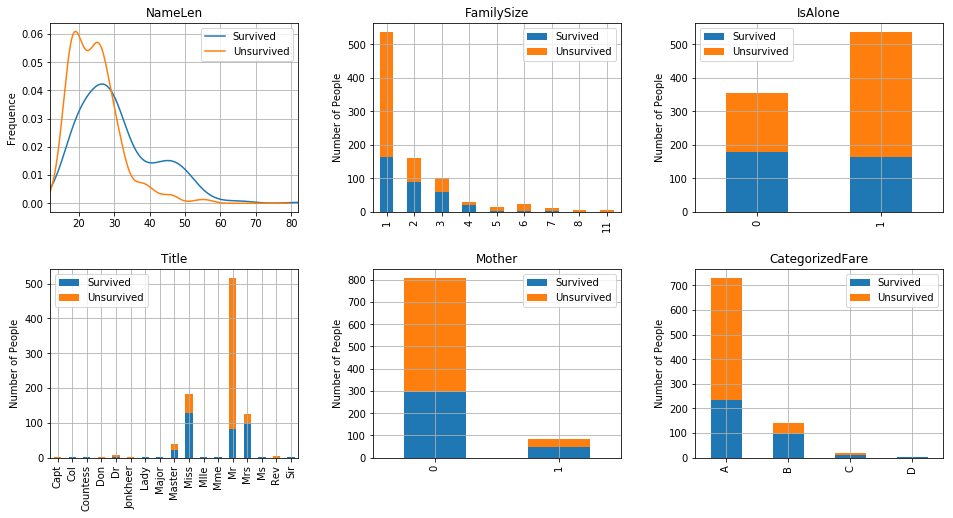

In [19]:
fig, axes = plt.subplots(2,3, figsize=(16, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# NameLen
plotSur('NameLen',1,axes[0,0])
# FamilySize
plotSur('FamilySize',2,axes[0,1])
# IsAlone
plotSur('IsAlone',2,axes[0,2])
# Title
plotSur('Title',2,axes[1,0])
# Mother
plotSur('Mother',2,axes[1,1])
# CategorizedFare
plotSur('CategorizedFare',2,axes[1,2])

plt.show()

可以发现以下这些特点：
* 姓名长度大于30左右的人存活率会更高一些 => 考虑直接分为两层
* 小家庭（FamilySize=2~4）的存活率会更高一些,而大家庭（FamilySize>=5）存活率都很低 => 考虑构建小家庭和大家庭的新特征
* 非独行的人存活率会比独行的人存活率更高一些
* 头衔的种类有很多，比较多的还是 Mr, Mrs, Miss, Master 这四种，有存活率的区别 => 考虑将其他出现的较少的合并为同一个类 Rare
* 母亲的存活率会更高一些
* 可以发现分层票价，越贵的存活率越高

根据上面的分析，整理一下新特征

In [20]:
# CateNameLen
train['CateNameLen']=train['NameLen'].apply(lambda x: 'L' if (x>=30) else 'S')

# SmallFamily
train['SmallFamily']=train['FamilySize'].apply(lambda x: 1 if (x>=2 and x<5) else 0)

# LargeFamily
train['LargeFamily']=train['FamilySize'].apply(lambda x: 1 if (x>=5) else 0)

# Title
train['Title']=train['Title'].apply(lambda x: 'Rare' if (x not in ['Mr','Mrs','Miss','Master']) else x)

# 删除特征
train.drop(['NameLen','FamilySize'],axis=1,inplace=True)

train.head()

,Survived,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,CategorizedAge_M,CategorizedAge_N,CategorizedAge_O,IsAlone,Title,Mother,CategorizedFare,CateNameLen,SmallFamily,LargeFamily
0,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,Mr,0,A,S,1,0
1,1,1,0,1,0,0,1,0,1,0,...,0,0,0,0,Mrs,0,B,L,1,0
2,1,0,0,0,0,1,1,0,0,0,...,0,0,0,1,Miss,0,A,S,0,0
3,1,1,0,1,0,0,1,0,0,0,...,0,0,0,0,Mrs,0,B,L,1,0
4,0,0,0,0,0,1,0,1,0,0,...,0,0,0,1,Mr,0,A,S,0,0


再看一下新特征与目标变量之间的关系

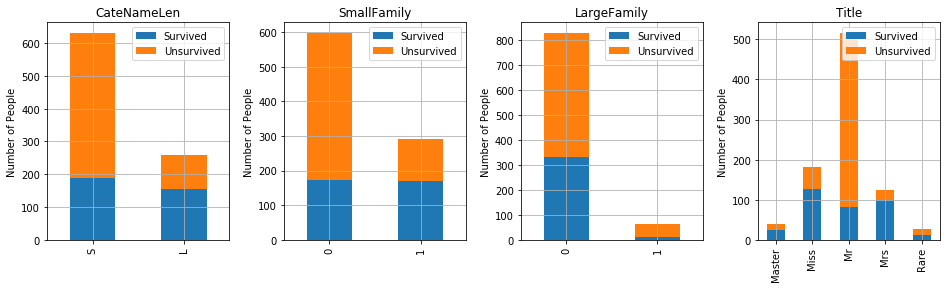

In [21]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(16, 4))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# CateNameLen
plotSur('CateNameLen',2,ax1)
# SmallFamily
plotSur('SmallFamily',2,ax2)
# LargeFamily
plotSur('LargeFamily',2,ax3)
# Title
plotSur('Title',2,ax4)

plt.show()

满意，都比较有区分度。

然后将他们也进行 OHE。需要 OHE 的有 Title, CategorizedFare, CateNameLen。

In [22]:
train=dummiesCate(train,['Title','CategorizedFare','CateNameLen'])
train.head()

,Survived,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,CategorizedFare_A,CategorizedFare_B,CategorizedFare_C,CategorizedFare_D,CateNameLen_L,CateNameLen_S
0,0,1,0,0,0,1,0,1,0,0,...,0,1,0,0,1,0,0,0,0,1
1,1,1,0,1,0,0,1,0,1,0,...,0,0,1,0,0,1,0,0,1,0
2,1,0,0,0,0,1,1,0,0,0,...,1,0,0,0,1,0,0,0,0,1
3,1,1,0,1,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0
4,0,0,0,0,0,1,0,1,0,0,...,0,1,0,0,1,0,0,0,0,1


查看一下特征之间的相关性。

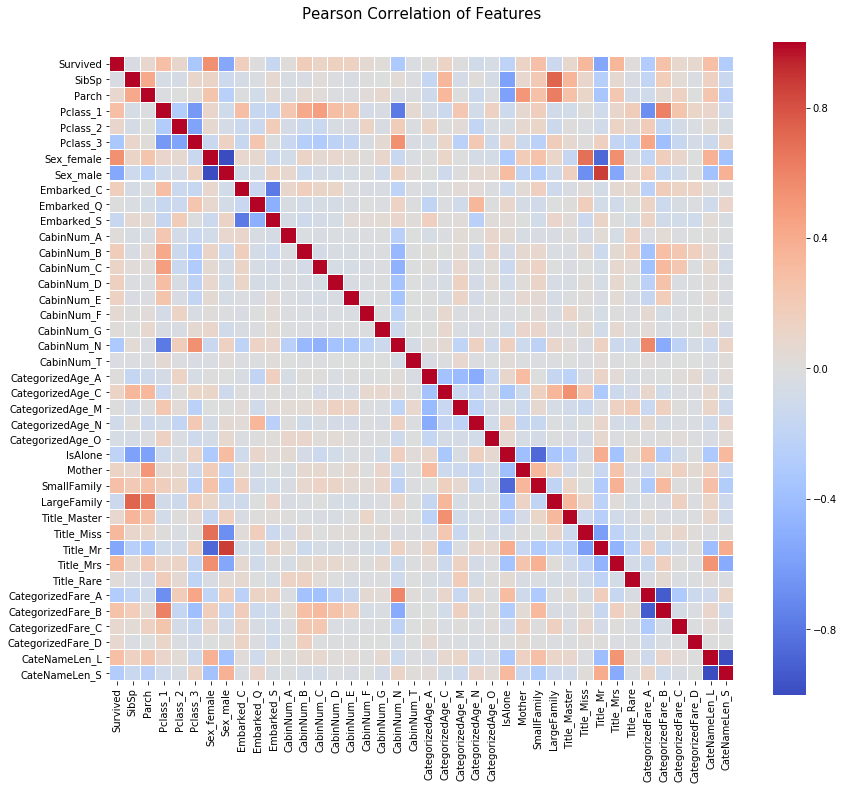

In [23]:
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap='coolwarm', linecolor='white', annot=False)
plt.show()

可以看到强相关的比较少。主要是二分类特征相关性比较强，或者是头衔和性别的相关。

基本没有很大问题。

### 3.3 处理测试集
对测试集进行同样的处理

首先处理缺失值，需要处理的有 Age, Fare 和 Cabin
* Age 和 Cabin 都使用训练集一样的处理方法就行
* Fare 训练集并没有处理，但是只缺失一个，而且Fare分布比较集中，所以考虑直接使用众数填充

In [24]:
test['CategorizedAge']=test['Age'].apply(lambda x: 'C' if x<=16 else ('A' if (x>16 and x<=40) else ('M' if (x>40 and x<=60) else ('O' if x>60 else 'N'))))
test.drop('Age',axis=1,inplace=True)

test['CabinNum']=test['Cabin'].apply(lambda x: 'N' if type(x)==float else x[0])
test.drop('Cabin',axis=1,inplace=True)

test.loc[(test.Fare.isnull()),'Fare']=float(test.Fare.mode())

# 查看缺失值情况-测试集
test.isnull().sum().to_frame().T

,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Embarked,CategorizedAge,CabinNum
0,0,0,0,0,0,0,0,0,0,0


然后构建新特征

In [25]:
# NameLen 姓名长度
test['NameLen'] = test['Name'].apply(len)

# FamilySize 家庭大小
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

# IsAlone 是否独行
test['IsAlone'] = test["FamilySize"].apply(lambda x: 1 if x==1 else 0)

# Title 姓名的头衔
test['Title'] = test['Name'].apply(get_title)
test['Title']=test['Title'].apply(lambda x: 'Rare' if (x not in ['Mr','Mrs','Miss','Master']) else x)

# Mother 母亲
test['Mother']=test.apply(lambda x: 1 if (x.CategorizedAge=='A' and x.Parch>=1) else 0 , axis = 1)

# CategorizedFare 分层票价
test['CategorizedFare']=test.Fare.apply(lambda x: 'A' if x<=50 else ('B' if (x>50 and x<=200) else ('C' if(x>200 and x<=400) else 'D')))

# CateNameLen
test['CateNameLen']=test['NameLen'].apply(lambda x: 'L' if (x>=30) else 'S')

# SmallFamily
test['SmallFamily']=test['FamilySize'].apply(lambda x: 1 if (x>=2 and x<5) else 0)

# LargeFamily
test['LargeFamily']=test['FamilySize'].apply(lambda x: 1 if (x>=5) else 0)

# 删除其他特征
test.drop(['Name','Ticket','Fare','NameLen','FamilySize'],axis=1,inplace=True)

test.head()

,Pclass,Sex,SibSp,Parch,Embarked,CategorizedAge,CabinNum,IsAlone,Title,Mother,CategorizedFare,CateNameLen,SmallFamily,LargeFamily
0,3,male,0,0,Q,A,N,1,Mr,0,A,S,0,0
1,3,female,1,0,S,M,N,0,Mrs,0,A,L,1,0
2,2,male,0,0,Q,O,N,1,Mr,0,A,S,0,0
3,3,male,0,0,S,A,N,1,Mr,0,A,S,0,0
4,3,female,1,1,S,A,N,0,Mrs,1,A,L,1,0


进行 OHE，需要 OHE 的有 Pclass, Sex, Embarked, CategorizedAge, CabinNum, Title, CategorizedFare, CateNameLen

In [26]:
test=dummiesCate(test,['Pclass', 'Sex', 'Embarked', 'CategorizedAge', 'CabinNum', 'Title', 'CategorizedFare', 'CateNameLen'])
test.head()

,SibSp,Parch,IsAlone,Mother,SmallFamily,LargeFamily,Pclass_1,Pclass_2,Pclass_3,Sex_female,...,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,CategorizedFare_A,CategorizedFare_B,CategorizedFare_C,CategorizedFare_D,CateNameLen_L,CateNameLen_S
0,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,1
1,1,0,0,0,1,0,0,0,1,1,...,0,0,1,0,1,0,0,0,1,0
2,0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,1
3,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,1
4,1,1,0,1,1,0,0,0,1,1,...,0,0,1,0,1,0,0,0,1,0


In [27]:
set(train.columns.tolist())-set(test.columns.tolist())

{'CabinNum_T', 'Survived'}

发现测试集没有在 T 船舱的，我们手动加一列

In [28]:
test['CabinNum_T']=0
# 重新排列一下列的顺序
test=test.ix[:,train.drop('Survived',axis=1).columns]
test.head()

,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,...,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,CategorizedFare_A,CategorizedFare_B,CategorizedFare_C,CategorizedFare_D,CateNameLen_L,CateNameLen_S
0,0,0,0,0,1,0,1,0,1,0,...,0,1,0,0,1,0,0,0,0,1
1,1,0,0,0,1,1,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0
2,0,0,0,1,0,0,1,0,1,0,...,0,1,0,0,1,0,0,0,0,1
3,0,0,0,0,1,0,1,0,0,1,...,0,1,0,0,1,0,0,0,0,1
4,1,1,0,0,1,1,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0


## 4 模型选择
### 4.1 模型训练
我们先建立一个类方便后面访问多个 Sklearn 中的模型。

In [29]:
# 后面需要用到的一些参数
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # 设置初始状态
NFOLDS = 5 # out-of-fold prediction 的折数
kf = KFold(n_splits = NFOLDS, random_state = SEED)

# 访问模型的类
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_
    
    def plot_learning_curve(self, x_train, y_train):
        train_sizes=np.linspace(.05, 1., 20)
        verbose=0
        train_sizes, train_scores, test_scores = learning_curve(self.clf, x_train, y_train, train_sizes=train_sizes,verbose=verbose)
        
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        
        plt.figure()
        plt.xlabel("Number of Samples")
        plt.ylabel("Score")
        plt.gca().invert_yaxis()
        plt.grid()
    
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="score of train set")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="score of cv set")
    
        plt.legend(loc="best")
        
        return plt

#### Out-of-Fold Predictions

In [30]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    all_acc=[]

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        y_te = y_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
        all_acc.append(accuracy_score(y_te,oof_train[test_index]))

    oof_test[:] = oof_test_skf.mean(axis=0)
    mean_acc=np.mean(all_acc)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1),mean_acc

#### 生成基础第一层模型
我们考虑使用的基础模型有以下这些：
* Logistic Regression
* Support Vector Machine
* Random Forest
* AdaBoost
* Gradient Boosting
* Extra Trees

参数的设置如下

In [31]:
# Logistic Regression
lr_params={
    'penalty':'l2',
    'n_jobs': -1,
}

# Support Vector Classifier
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

# Random Forest
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# AdaBoost
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Extra Trees
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

In [32]:
# 构建 6 个基础模型对象
lr = SklearnHelper(clf=LogisticRegression, seed=SEED, params=lr_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)

In [33]:
# 构建训练集，测试集和目标变量
# 构建成 Numpy 数组方便输入模型
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [34]:
%%time
# 开始训练
lr_oof_train, lr_oof_test, lr_acc = get_oof(lr,x_train, y_train, x_test) # Logistic Regression
svc_oof_train, svc_oof_test, svc_acc = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier
rf_oof_train, rf_oof_test ,rf_acc = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test ,ada_acc= get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test ,gb_acc= get_oof(gb,x_train, y_train, x_test) # Gradient Boost
et_oof_train, et_oof_test ,et_acc= get_oof(et, x_train, y_train, x_test) # Extra Trees

print("训练完成")

训练完成
Wall time: 33.5 s


In [35]:
# 查看特征重要性 但是只有树类模型才能使用 feature_importances 方法
rf_features = rf.feature_importances(x_train,y_train).tolist()
ada_features = ada.feature_importances(x_train, y_train).tolist()
gb_features = gb.feature_importances(x_train,y_train).tolist()
et_features = et.feature_importances(x_train, y_train).tolist()

df=pd.DataFrame({'rf':rf_features, 'ada':ada_features,'gb':gb_features,'et':et_features}).T
df.columns=train.columns
df

,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,...,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,CategorizedFare_A,CategorizedFare_B,CategorizedFare_C,CategorizedFare_D,CateNameLen_L,CateNameLen_S
rf,0.025624,0.019659,0.046181,0.018180,0.069748,0.132968,0.129989,0.012540,0.003668,0.011187,...,0.025269,0.171877,0.028142,0.005356,0.035582,0.023965,0.001364,0.001459,0.023777,0.021419
ada,0.042000,0.178000,0.024000,0.002000,0.006000,0.112000,0.092000,0.004000,0.002000,0.002000,...,0.128000,0.064000,0.100000,0.014000,0.010000,0.000000,0.004000,0.002000,0.004000,0.002000
gb,0.028733,0.016450,0.012317,0.006592,0.080064,0.013729,0.007198,0.012921,0.006781,0.007949,...,0.004679,0.432880,0.003557,0.039224,0.010666,0.007189,0.004269,0.004574,0.010556,0.015786
et,0.015128,0.010823,0.031203,0.020329,0.068832,0.129384,0.143908,0.008958,0.005476,0.011829,...,0.045690,0.169103,0.043950,0.007012,0.022596,0.014158,0.002644,0.002068,0.018779,0.018119


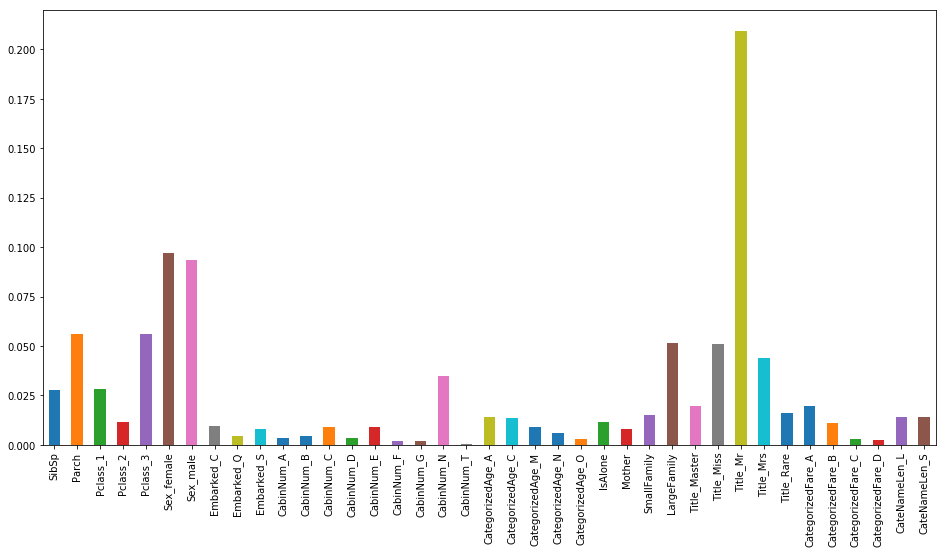

In [36]:
# 图表展示
fig=plt.figure(figsize=(16,8))
df.mean(axis=0).plot(kind='bar')
plt.show()

lr     0.820451
svc    0.820400
rf     0.851867
ada    0.821587
gb     0.805850
et     0.819289
dtype: float64


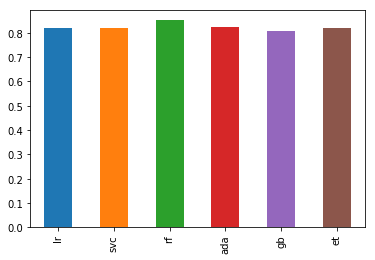

In [37]:
# 查看各个模型的准确度
df=pd.Series({'lr':lr_acc, 'svc':svc_acc,'rf':rf_acc,'ada':ada_acc,'gb':gb_acc,'et':et_acc})
print(df)
df.plot(kind='bar')

基本上都差不多，随机森林稍微高一点点。

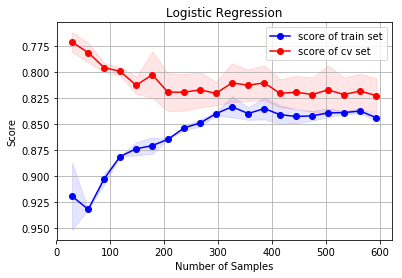

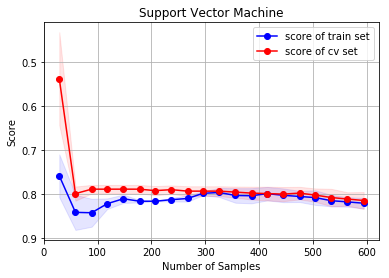

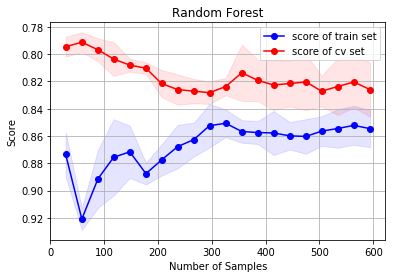

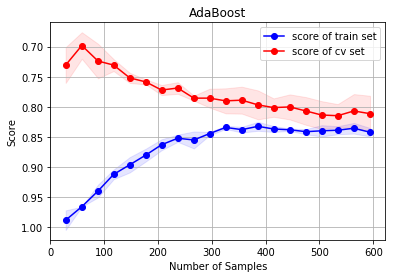

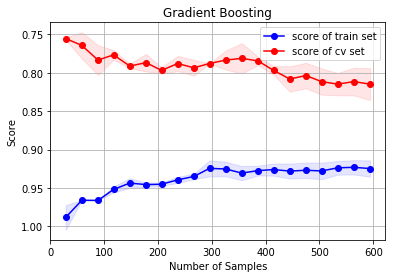

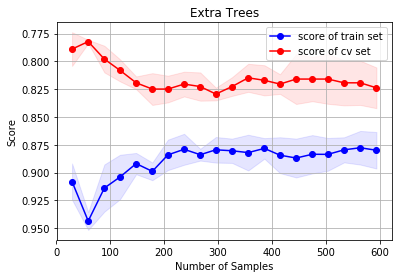

Wall time: 5min 17s


In [38]:
%%time
lr.plot_learning_curve(x_train,y_train)
plt.title('Logistic Regression')
svc.plot_learning_curve(x_train,y_train)
plt.title('Support Vector Machine')
rf.plot_learning_curve(x_train,y_train)
plt.title('Random Forest')
ada.plot_learning_curve(x_train,y_train)
plt.title('AdaBoost')
gb.plot_learning_curve(x_train,y_train)
plt.title('Gradient Boosting')
et.plot_learning_curve(x_train,y_train)
plt.title('Extra Trees')
plt.show()

### 4.2 模型融合
将第一层模型的输出作为新的特征

In [39]:
base_predictions_train = pd.DataFrame( {'LogisticRegression':rf_oof_train.ravel(),
                                        'SupportVectorMachine':svc_oof_train.ravel(),
                                        'RandomForest': rf_oof_train.ravel(),
                                        'ExtraTrees': et_oof_train.ravel(),
                                        'AdaBoost': ada_oof_train.ravel(),
                                        'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,LogisticRegression,SupportVectorMachine,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,1.0,0.0,0.0,1.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0


看看各个模型之间的相关性

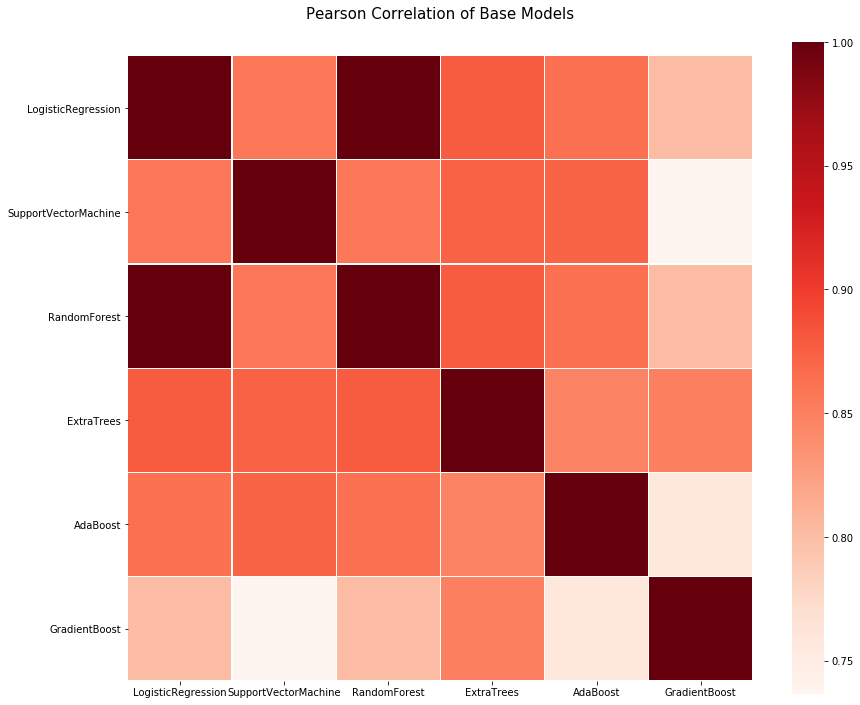

In [41]:
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Base Models', y=1.05, size=15)
sns.heatmap(base_predictions_train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap='Reds', linecolor='white', annot=False)
plt.show()

可以看到 Logistic Regression 和 Random Forest 的相关性很高，或许使用一个比较好？暂且先使用两个看看

In [46]:
x_second_train = np.concatenate(( lr_oof_train,et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_second_test = np.concatenate(( lr_oof_test,et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

使用 XGBoost 作为第二层函数

In [47]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_second_train, y_train)
predictions = gbm.predict(x_second_test)

In [49]:
# 输出预测结果
StackingSubmission = pd.DataFrame({ 'PassengerId': Pid_test,
                            'Survived': predictions })
StackingSubmission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [50]:
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

？？？分数竟然还是 0.78947

试试第二层，不加逻辑回归

In [51]:
x_second_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_second_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_second_train, y_train)
predictions = gbm.predict(x_second_test)

# 输出预测结果
StackingSubmission = pd.DataFrame({ 'PassengerId': Pid_test,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission2.csv", index=False)

…………放弃了，分数仍然是 0.78947

不使用 Stacking， Voting 试试？

In [52]:
from sklearn.ensemble import VotingClassifier

voting_clf=VotingClassifier(estimators=[
    ('lr',lr.clf),
    ('svc',svc.clf),
    ('rf',rf.clf),
    ('et',et.clf),
    ('ada',ada.clf),
    ('gb',gb.clf)],voting='hard')

In [53]:
voting_clf.fit(x_second_train,y_train)
predictions =voting_clf.predict(x_second_test)

# 输出预测结果
StackingSubmission = pd.DataFrame({ 'PassengerId': Pid_test,
                            'Survived': predictions })
StackingSubmission.to_csv("VotingSubmission.csv", index=False)

提高了一点点，分数为 0.79425

暂且先这样吧

#### 【References】
\[1][kaggle-泰坦尼克幸存者预测TitanicLvPeiyuan](https://www.kaggle.com/lvpeiyuan/titaniclvpeiyuan)<br>
\[2][机器学习系列(3)_逻辑回归应用之Kaggle泰坦尼克之灾](https://blog.csdn.net/han_xiaoyang/article/details/49797143)<br>
\[3][Introduction to Ensembling/Stacking in Python](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python)<br>
\[4][Titanic best working Classifier](https://www.kaggle.com/sinakhorami/titanic-best-working-classifier)<br>
\[5][集成学习voting Classifier在sklearn中的实现](https://blog.csdn.net/m0_37725003/article/details/81095555)